<a href="https://colab.research.google.com/github/Aduwix/Toxic_comments_classification/blob/main/Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Réseaux de neurones
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [18]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


On ne prend pas la totalité du dataset pour l'entraînement pour ne pas passer trop de temps sur l'apprentissage.

In [19]:
len(data.index)
data = data.iloc[:20000, :]

# Etude du jeu de données

Une première étape consiste à enlever certains caractères spéciaux présents dans les commentaires.

In [20]:
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('\ufeff', ''))
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('\xa0', ''))
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('&#39;', ' '))

On veut maintenant essayer de comprendre notre jeu de données avec différentes caractéristiques, on commence par la fréquence des commentaires selon leur classe type.

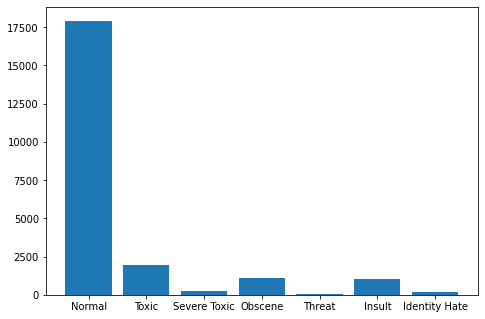

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ["Normal", "Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]

#On définit nos différents labels
labels = data.columns[2:]

values = [len(data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)])]
for column in labels:
  values.append(data[column].value_counts().to_numpy()[1])

ax.bar(types,values)
plt.show()

On remarque ici que le nombre de commentaires dits "normaux" est bien supérieur au nombre de commentaires toxiques de tous types. On remarque aussi que certaines classes sont plus présentes que d'autres: 'toxic', 'obscene' et 'insult' ont plus d'exemples que 'severe_toxic', 'threat' et 'identity hate'.

On peut aussi regarder la taille de nos commentaires

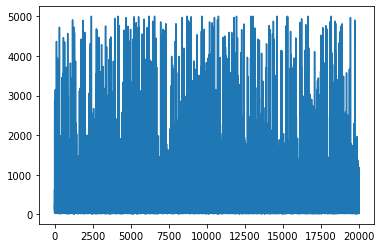

In [22]:
data['comment_text'].str.len().plot()

On remarque que la longueur des commentaires semble uniformément distribuée.

In [23]:
print("Taille Moyenne d'un commentaire (nombre de caractères): {} ".format(np.mean(data['comment_text'].str.len())))
average_size = np.mean([len(comment.split()) for comment in data['comment_text']])
print("Taille Moyenne d'un commentaire (nombre de mots): {} ".format(average_size))

Taille Moyenne d'un commentaire (nombre de caractères): 396.35155 
Taille Moyenne d'un commentaire (nombre de mots): 67.71635 


In [24]:
print("Taille Maximale d'un commentaire (nombre de caractères): {} ".format(np.max(data['comment_text'].str.len())))
max_size = np.max([len(comment.split()) for comment in data['comment_text']])
print("Taille Maximale d'un commentaire (nombre de mots): {} ".format(max_size))

Taille Maximale d'un commentaire (nombre de caractères): 5000 
Taille Maximale d'un commentaire (nombre de mots): 1403 


# Préparation des données

L'objectif est maintenant de nettoyer le jeu de données. On va notamment essayer de remplacer les contractions et abreviations les plus courantes.

In [25]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


On définit plusieurs fonctions nous permettant de nettoyer les commentaires.

In [26]:
def clean(comment): 
            
    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)  
    comment = re.sub(r"donå«t", "do not", comment)  
    
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"yrs", "years", comment)
    comment = re.sub(r"hrs", "hours", comment)
    comment = re.sub(r"2morow|2moro", "tomorrow", comment)
    comment = re.sub(r"2day", "today", comment)
    comment = re.sub(r"4got|4gotten", "forget", comment)
    comment = re.sub(r"b-day|bday", "b-day", comment)
    comment = re.sub(r"mother's", "mother", comment)
    comment = re.sub(r"mom's", "mom", comment)
    comment = re.sub(r"dad's", "dad", comment)
    comment = re.sub(r"hahah|hahaha|hahahaha", "haha", comment)
    comment = re.sub(r"lmao|lolz|rofl", "lol", comment)
    comment = re.sub(r"thanx|thnx", "thanks", comment)
    comment = re.sub(r"goood", "good", comment)
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"some1", "someone", comment)
    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)
    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"<3", "love", comment)
    # Urls
    comment = re.sub(r"http\S+", "", comment)
    # Numbers
    comment = re.sub(r'[0-9]', '', comment)
    # Eliminating the mentions
    comment = re.sub("(@[A-Za-z0-9_]+)","", comment)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        comment = comment.replace(p, '')
        
    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')
        
    # Tokenize
    comment_words = word_tokenize(comment)
    
    # Eliminating the word if its length is less than 3
    comment = [w for w in comment_words if len(w)>2]
    
    # remove stopwords
    comment = [w.lower() for w in comment if not w in stop_words]  
    
    
    # join back
    comment = ' '.join(comment)
        
        
    return comment

In [27]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(comment):
    t=[]
    words=comment.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

La fonction prepare_string permet d'appliquer les deux traitements définis précédemment pour netoyer les commentaires.

In [28]:
def prepare_string(comment):
  comment = clean(comment)
  comment = convert_abbrev_in_text(comment)
  return comment

In [29]:
%%time
data['comment_text'] = data['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data['comment_text'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment_text'], inplace=True)

CPU times: user 14.5 s, sys: 36.9 ms, total: 14.6 s
Wall time: 14.6 s


In [30]:
data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir hero any chance remember page,0,0,0,0,0,0
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism matt shirvington article revert...,0,0,0,0,0,0
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0


Nos commentaires sont maintenant nettoyés et prêts à être traités.

# Passage du texte dans un format structuré

In [31]:
corpus_size = int(10000)
#corpus_size = int(800)
#On va maintenant prendre un échantillon de notre dataset car TfidfVectorizer() a besoin d'énormément de ram pour ses calculs si on prend le dataset entier

sample_data = data.iloc[:corpus_size, :]

comments = sample_data['comment_text']

#On récupère maintenant les labels
y = sample_data.drop(columns=["comment_text", "id"]).values[:int(corpus_size)]


tfIdfVectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
X = tfIdfVectorizer.fit_transform(comments).toarray()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Entraînement du modèle baseline

Nous étions à la base partis sur un modèle de RandomForestClassifier comme dans les TP.
Nous avons donc constaté le manque de précision du modèle et fait une analyse afin d'améliorer la précision.
Mais nous nous sommes finalement rendu compte que ce modèle ne peut sortir qu'une seule classe à la fois. Autrement dit, un commentaire classé comme 'toxic' par le modèle ne sera jamais classé 'obscene' car le modèle ne pourra pas sortir deux labels en même temps.
Il faut donc utiliser un modèle permettant de faire de la multi-label classification.
On utilise ici OneVsRestClassifier.

In [33]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=15, random_state=1), n_jobs=-1)
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=15,
                                                     random_state=1),
                    n_jobs=-1)

On analyse maintenant les performances de notre modèle baseline

On regarde tout d'abord les performances sur les données d'entraînement

In [34]:
print(y_train[4], y_train[10])
print(model.predict([X_train[4], X_train[10]]))

training_predictions = model.predict(X_train)
print(classification_report(y_train,training_predictions, zero_division = 1))   

print(accuracy_score(y_train, training_predictions))

[0 0 0 0 0 0] [0 0 0 0 0 0]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       667
           1       1.00      0.93      0.96        71
           2       1.00      0.97      0.99       360
           3       1.00      0.78      0.88        23
           4       1.00      0.96      0.98       323
           5       1.00      0.87      0.93        55

   micro avg       1.00      0.96      0.98      1499
   macro avg       1.00      0.91      0.95      1499
weighted avg       1.00      0.96      0.98      1499
 samples avg       1.00      1.00      1.00      1499

0.9931428571428571


On voit ici que nous avons une précision de 99%.

Regardons maintenant les performances du modèle sur des données jamais rencontrées.

In [35]:
predictions = model.predict(X_test)
print(classification_report(y_test,predictions, zero_division = 1))   

print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.54      0.67       303
           1       0.50      0.03      0.06        29
           2       0.92      0.54      0.68       167
           3       1.00      0.00      0.00        10
           4       0.84      0.30      0.44       171
           5       0.50      0.04      0.07        28

   micro avg       0.88      0.43      0.58       708
   macro avg       0.77      0.24      0.32       708
weighted avg       0.85      0.43      0.56       708
 samples avg       0.99      0.93      0.93       708

0.9053333333333333


On remarque que nous avons une accuracy de 90%. Cela peut sembler correct mais on peut penser que, la dataset ayant en majorité des commentaires normaux, le modèle prédit qu'un commentaire est normal pour chaque type de commentaire.

In [36]:
def analysePredictions(predictions, y_test):
  num_col = len(predictions[0])
  num_rows = len(predictions)

  report = []

  for label in range(num_col):
    true_positive = false_positive = true_negative = false_negative = count = 0
    for i in range(num_rows):
      pred = predictions[i][label]
      answer = y_test[i][label]
      if pred == 1:
        if answer == 1:
          count += 1
          true_positive += 1
        else:
          false_positive += 1
      else:
        if answer == 0:
          true_negative += 1
        else:
          count += 1
          false_negative += 1
    report.append({
        'COUNT': count,
        'TP': true_positive,
        'FP': false_positive,
        'TN': true_negative,
        'FN': false_negative
    })
  return report

In [37]:
report = analysePredictions(predictions, y_test)

for i, label in enumerate(labels):
  print(
  """
  {}:
      Count: {}
      
        -True positive: {}
        -False positive: {}
        -True negative: {}
        -False negative: {} 

{}
  """.format(label, report[i]['COUNT'], report[i]['TP'], report[i]['FP'], report[i]['TN'], report[i]['FN'], confusion_matrix(y_test[:, i], predictions[:,i]))#On a aussi la possibilité d'utiliser confusion_matrix pour déterminer ces valeurs
  )


  toxic:
      Count: 303
      
        -True positive: 163
        -False positive: 21
        -True negative: 2676
        -False negative: 140 

[[2676   21]
 [ 140  163]]
  

  severe_toxic:
      Count: 29
      
        -True positive: 1
        -False positive: 1
        -True negative: 2970
        -False negative: 28 

[[2970    1]
 [  28    1]]
  

  obscene:
      Count: 167
      
        -True positive: 91
        -False positive: 8
        -True negative: 2825
        -False negative: 76 

[[2825    8]
 [  76   91]]
  

  threat:
      Count: 10
      
        -True positive: 0
        -False positive: 0
        -True negative: 2990
        -False negative: 10 

[[2990    0]
 [  10    0]]
  

  insult:
      Count: 171
      
        -True positive: 51
        -False positive: 10
        -True negative: 2819
        -False negative: 120 

[[2819   10]
 [ 120   51]]
  

  identity_hate:
      Count: 28
      
        -True positive: 1
        -False positive: 1
        -

En analysant ces indicateurs, on se rend alors compte qu'en réalité, le modèle n'arrive pas à classer les commentaires toxiques en général.
La bonne accuracy provient ici du fait que la majorité des commentaires étant normaux et du fait que le modèle considère la grande majorité des commentaires comme normaux même s'ils certains toxiques.
Le modèle n'est donc pas performant.
La méthode utilisant le tfidf ne semble pas être réellement performante.
En effet, le modèle ne semble pas être capable de généraliser.

# Itération de la modélisation 

Nous allons maintenant tenter d'amliorer les performances de notre modèle en passant par un réseau de neurones.

Hyperparamètres

In [90]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 50        # Maximum size of a comment
truncating='post'      # Truncates the comment if it is longer than max_length
padding='post'    # Adds padding to the end of the comment if it is shorter than max_length
oov_token = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(data)
test_portion=.25

In [91]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')

In [92]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(data["comment_text"])

On a maintenant un vecteur de mapping avec nos mots de notre vocabulaire

In [93]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'of': 4,
 'and': 5,
 'a': 6,
 'you': 7,
 'i': 8,
 'is': 9,
 'that': 10,
 'in': 11,
 'it': 12,
 'for': 13,
 'this': 14,
 'not': 15,
 'on': 16,
 'be': 17,
 'as': 18,
 'have': 19,
 'are': 20,
 'your': 21,
 'with': 22,
 'if': 23,
 'article': 24,
 'was': 25,
 'or': 26,
 'but': 27,
 'page': 28,
 'wikipedia': 29,
 'my': 30,
 'an': 31,
 'from': 32,
 'by': 33,
 'do': 34,
 'at': 35,
 'me': 36,
 'about': 37,
 'so': 38,
 'talk': 39,
 'what': 40,
 'can': 41,
 'there': 42,
 'all': 43,
 'has': 44,
 'will': 45,
 'please': 46,
 'no': 47,
 'would': 48,
 'one': 49,
 'like': 50,
 'just': 51,
 'they': 52,
 'he': 53,
 'which': 54,
 'any': 55,
 'been': 56,
 'should': 57,
 'more': 58,
 'we': 59,
 "don't": 60,
 'some': 61,
 'other': 62,
 'who': 63,
 'here': 64,
 'see': 65,
 'also': 66,
 'his': 67,
 'think': 68,
 'because': 69,
 'know': 70,
 'how': 71,
 'edit': 72,
 'am': 73,
 "i'm": 74,
 'people': 75,
 'why': 76,
 'up': 77,
 'only': 78,
 "it's": 79,
 'out': 80,
 'articles': 8

In [94]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

210338


In [95]:
sequences = tokenizer.texts_to_sequences(data["comment_text"])
x = pad_sequences(sequences, truncating=truncating, padding=padding, maxlen=max_length)
#x = np.asarray(x).astype(np.float32)

In [96]:
sequences[0]

[689,
 76,
 2,
 127,
 131,
 178,
 30,
 673,
 4512,
 12053,
 1117,
 87,
 332,
 52,
 2279,
 11449,
 51,
 6865,
 16,
 61,
 2757,
 149,
 8,
 2938,
 35,
 118,
 1222,
 15191,
 2826,
 5,
 46,
 60,
 245,
 2,
 366,
 32,
 2,
 39,
 28,
 144,
 74,
 3463,
 90,
 3086,
 4584,
 2274,
 986]

# Initialisation du modèle

Nous allons dans un premier temps créer un modèle à partir de rien.

In [97]:
tf.keras.utils.set_random_seed(123)

model = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length),
     tf.keras.layers.LSTM(64),
     tf.keras.layers.Dense(len(labels), activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           21033900  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 21,076,530
Trainable params: 21,076,530
Non-trainable params: 0
_________________________________________________________________


On a notre modèle. Il faut maintenant l'entraîner.

In [98]:
num_epochs = 30

On définit nos ensembles d'entraînement et de test.

In [99]:
y = data.drop(columns=["comment_text", "id"]).values[:len(x)]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_portion)

On entraîne le modèle.

In [100]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=256, epochs = num_epochs, validation_data = (np.array(X_test), np.array(y_test)) ,verbose=1)
print("Training Complete")

Epoch 1/30
468/468 [==============================] - 19s 37ms/step - loss: 0.1584 - accuracy: 0.9263 - val_loss: 0.1359 - val_accuracy: 0.9941
Epoch 2/30
468/468 [==============================] - 15s 33ms/step - loss: 0.1158 - accuracy: 0.9941 - val_loss: 0.0992 - val_accuracy: 0.9941
Epoch 3/30
468/468 [==============================] - 15s 32ms/step - loss: 0.0946 - accuracy: 0.9913 - val_loss: 0.1029 - val_accuracy: 0.9602
Epoch 4/30
468/468 [==============================] - 15s 33ms/step - loss: 0.0759 - accuracy: 0.9910 - val_loss: 0.0774 - val_accuracy: 0.9882
Epoch 5/30
468/468 [==============================] - 15s 33ms/step - loss: 0.0591 - accuracy: 0.9928 - val_loss: 0.0581 - val_accuracy: 0.9941
Epoch 6/30
468/468 [==============================] - 15s 33ms/step - loss: 0.0448 - accuracy: 0.9942 - val_loss: 0.0549 - val_accuracy: 0.9940
Epoch 7/30
468/468 [==============================] - 15s 33ms/step - loss: 0.0374 - accuracy: 0.9941 - val_loss: 0.0564 - val_accuracy:

On remarque ici que notre modèle basé sur un réseau de neurones avec une couche d'embeddings, une couche LSTM et une simple couche dense de sortie nous permet d'avoir une précision très élevée

In [101]:
def analyseComment(comments):
  if isinstance(comments, str): #La fonction peut prendre en paramètre une simple string 
    comments = [comments]
  sequences = tokenizer.texts_to_sequences(comments)
  x = pad_sequences(sequences, truncating=truncating, padding=padding, maxlen=max_length)

  predictions = model.predict(x)
  predictions = (predictions >= .5)

  result = []

  for i, pred in enumerate(predictions):
    tmp = []
    for j, label in enumerate(labels):
      if pred[j]:
        tmp.append(label)
    
    if not tmp: #Si aucun label n'est choisi, alors le commentaire est normal
      tmp.append('normal')

    result.append(tmp)
  
  return result

In [102]:
analyseComment(["cocksucker before you piss around work", "cock video cool", "cool video dude i love you"])

[[9.9998248e-01 5.5004388e-01 9.9838769e-01 1.6752004e-03 9.8488301e-01
  1.9069269e-02]
 [9.2226297e-01 3.8675560e-05 2.5932255e-01 3.2901968e-07 5.5470147e-05
  1.1042086e-07]
 [5.7477031e-05 3.2980461e-06 4.5466727e-06 1.2057548e-06 1.8514100e-06
  2.0042398e-07]]
[[ True  True  True False  True False]
 [ True False False False False False]
 [False False False False False False]]


[['toxic', 'severe_toxic', 'obscene', 'insult'], ['toxic'], ['normal']]

In [106]:
test2 = model.predict(X_test)
test2 = (test2 >= .5)
print(accuracy_score(y_test, test2))

0.8987541673977891
